# "Best" Disk Resonator + 2Waveguides Simulation Code so far

Current Setup: try to reproduce Paper from Hagness - FDTD Microcavity Simulations 

(a) nonresonant signal (193:4 THz), (b) on-resonance signal, first-order radial mode
( 189:2 THz), (c) second-order radial mode resonance ( 191:3 THz), and (d) third-order radial mode resonance (187:8 THz).

### Build Geometry

     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
     block, center = (0,2.882,0)
          size (20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
     block, center = (0,-2.882,0)
          size (20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)


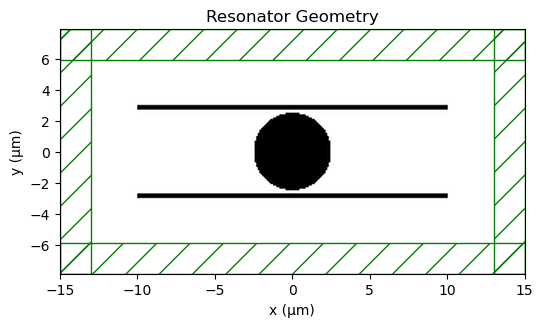

In [37]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np

c0 = 299792458  # m/s
um_scale = 1e-6  # 1 µm in m

# -----------------------------
# Simulation parameters
# -----------------------------

# Materials
gaas = mp.Medium(epsilon=np.square(3.2)) # not really gaas, just kept the name, now epsilon used from paper
air = mp.Medium(epsilon=1)

# Disk and waveguide geometry
disk_radius = 2.5
wg_length = 20
wg_width = 0.3
gap = 0.232  # distance between disk and waveguides

# Simulation cell size
cell_x = wg_length + 10
cell_y = 2*(disk_radius + gap + wg_width/2) + 10
cell = mp.Vector3(cell_x, cell_y, 0)

# PML layers
pml_layers = [mp.PML(2.0)]

# -----------------------------
# Geometry: disk + two waveguides
# -----------------------------
geometry = [
    mp.Cylinder(radius=disk_radius, height=mp.inf, center=mp.Vector3(0,0), material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, disk_radius + gap + wg_width/2),
             material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, -disk_radius - gap - wg_width/2),
             material=gaas)
]

# -----------------------------
# Plot geometry
# -----------------------------
resolution = 10  # pixels/um

sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    resolution=resolution)

fig, ax = plt.subplots(figsize=(6,6))
sim.plot2D(ax=ax)
plt.title("Resonator Geometry")
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.show()


### Search for resonance using Gaussian Source, Flux Monitors at Bus and Drop port

-----------
Initializing structure...
time for choose_chunkdivision = 0.00352693 s
Working in 2D dimensions.
Computational cell is 30 x 15.75 x 0 with resolution 24
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
     block, center = (0,2.882,0)
          size (20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
     block, center = (0,-2.882,0)
          size (20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
time for set_epsilon = 0.471601 s
-----------
on time step 1110 (time=23.125), 0.00360862 s/step
on time step 2234 (time=46.5417), 0.00356072 s/step
field decay(t = 50.02083333333333): 2.28720402198799e-06 / 2.28720402198799e-06 = 1.0
on time step 3315 (time=69.0625), 0.00370121 s/step
on time step 4338 (time=90.375), 0.00391383 s/ste

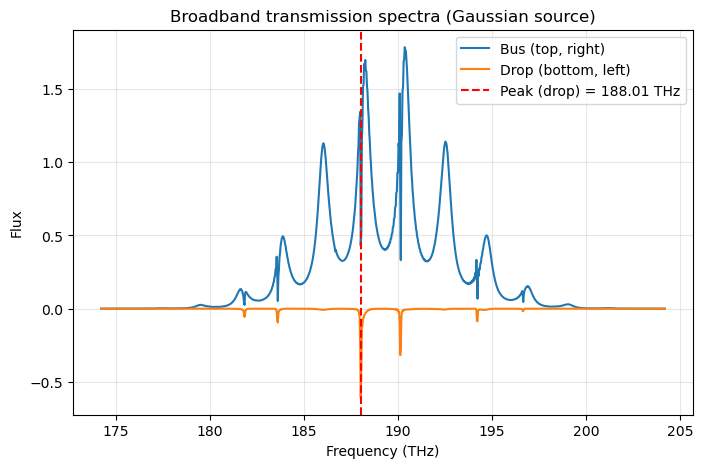

In [ ]:

# -----------------------------
# Source (broadband run)
# -----------------------------
source_x = -wg_length/2
source_y = disk_radius + gap + wg_width/2

f_thz = 189.2  # target resonance frequency in THz
f_cen = f_thz * um_scale * 1e12 / c0  # convert to Meep freq (1/um)
# bandwidth for Gaussian source
df_thz = 30  # in THz
df = df_thz * um_scale * 1e12 / c0  # convert to Meep freq (1/um)


#fmin = 0.3
#fmax = 0.35
#df = fmax - fmin

nfreq = 1000
resolution = 24  # pixels/um

sources = [mp.Source(mp.GaussianSource(frequency=f_cen, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, wg_width, 0))]

# -----------------------------
# Flux monitors
# -----------------------------
flux_region_bus = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1,
                                                  disk_radius + gap + wg_width/2),
                                size=mp.Vector3(0, wg_width, 0))

# Drop port moved to left side of lower waveguide (same side as source, opposite waveguide)
flux_region_drop = mp.FluxRegion(center=mp.Vector3(-wg_length/2 + 1,
                                                   -disk_radius - gap - wg_width/2),
                                 size=mp.Vector3(0, wg_width, 0))

# -----------------------------
# First Simulation (spectra)
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

trans_flux_bus = sim.add_flux(f_cen, df, nfreq, flux_region_bus)
trans_flux_drop = sim.add_flux(f_cen, df, nfreq, flux_region_drop)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(), 1e-5))


frequencies = np.array(mp.get_flux_freqs(trans_flux_bus))
flux_bus = np.array(mp.get_fluxes(trans_flux_bus))
flux_drop = np.array(mp.get_fluxes(trans_flux_drop))

# -----------------------------
# Find resonance from max |flux_drop|
# -----------------------------
res_freq = frequencies[np.argmax(np.abs(flux_drop))]
print(f"Resonance frequency (max |drop port|): {res_freq:.6f} 1/um")

## Conversion: Meep freq (1/um) → THz
freq_thz = frequencies * c0 / um_scale / 1e12
res_freq_thz = res_freq * c0 / um_scale / 1e12

# Plot
plt.figure(figsize=(16,5))
plt.plot(freq_thz, flux_bus, label='Bus (top, right)')
plt.plot(freq_thz, flux_drop, label='Drop (bottom, left)')
plt.axvline(res_freq_thz, color='r', ls='--', label=f'Peak (drop) = {res_freq_thz:.2f} THz')
plt.xlabel('Frequency (THz)')
plt.ylabel('Flux')
plt.title('Broadband transmission spectra (Gaussian source)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



### New Run with single freq source, taken from gaussian run above the freq with most drop port flux

/home/ku/miniforge3/envs/meep/lib/python3.9/site-packages/meep/visualization.py:1469: UserWarning: Warning: The 'sim' argument in Animate2D is deprecated and has no effect. It will be removed in a future release.
  warnings.warn(


-----------
Initializing structure...
time for choose_chunkdivision = 0.000447989 s
Working in 2D dimensions.
Computational cell is 30 x 15.75 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
     

block, center = (0,2.882,0)
          size (20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
     block, center = (0,-2.882,0)
          size (20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
time for set_epsilon = 0.463661 s
-----------


FloatProgress(value=0.0, description='0% done ', max=3000.0)

     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
     block, center = (0,2.882,0)
          size (20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
     block, center = (0,-2.882,0)
          size (20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
Meep progress: 36.925000000000004/3000.0 = 1.2% done in 4.0s, 321.1s to go
on time step 1479 (time=36.975), 0.00270612 s/step
Meep progress: 77.67500000000001/3000.0 = 2.6% done in 8.0s, 301.2s to go
on time step 3110 (time=77.75), 0.00245295 s/step
Meep progress: 119.95/3000.0 = 4.0% done in 12.0s, 288.3s to go
on time step 4800 (time=120), 0.00237418 s/step
Meep progress: 163.275/3000.0 = 5.4% done in 16.0s, 278.1s to go
on time step 6538 (time=163.45), 0.00230339 s/step
Meep progress: 206.0750

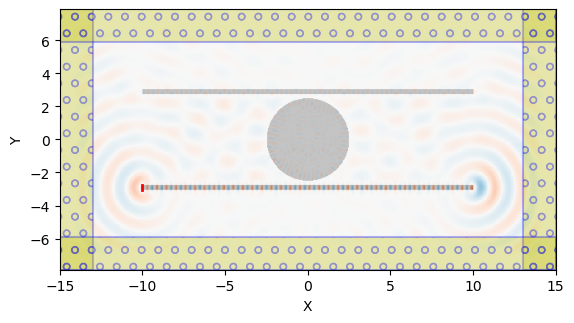

In [ ]:
from IPython.display import display,Video  # for inline playback in VS Code / Jupyter

# -----------------------------
# Single (resonance)-frequency run, for field snapshots or Video
# -----------------------------

typeof_run = 1  # 0: "snapshots" or 1: "video"

# -----------------------------
# Source
# -----------------------------
source_x = -wg_length/2
source_y = - (disk_radius + gap + wg_width/2)


nfreq = 500
resolution = 20  # pixels/um


sources_res = [mp.Source(mp.ContinuousSource(frequency=res_freq),
                         component=mp.Ez,
                         center=mp.Vector3(source_x, source_y),
                         size=mp.Vector3(0, wg_width, 0))]

sim_res = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=sources_res,
                        boundary_layers=pml_layers,
                        resolution=resolution)

if typeof_run == 0:

    ez_data = []
    def store_fields(sim):
        ez_data.append(sim.get_array(center=mp.Vector3(),
                                    size=cell,
                                    component=mp.Ez))

    sim_res.run(mp.at_every(20, store_fields), until=800)

    # -----------------------------
    # Plot Ez snapshots
    # -----------------------------
    for i, field in enumerate(ez_data):
        if i % 10 == 0:
            plt.figure(figsize=(12,6))
            plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
                    extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2])
            plt.colorbar(label="Ez field")
            plt.title(f"Ez snapshot {i*20} time units at res_freq={res_freq:.4f}")
            plt.xlabel("x (µm)")
            plt.ylabel("y (µm)")
            plt.show()


elif typeof_run == 1:

    # -----------------------------
    # Create the animation object
    # -----------------------------
    animate = mp.Animate2D(
        sim=sim_res,               
        fields=mp.Ez,
        normalize=True,
        realtime=False,
        field_parameters={"alpha":0.8, "cmap":"RdBu", "interpolation":"none"},
        boundary_parameters={"hatch":"o","linewidth":1.5,"facecolor":"y",
                            "edgecolor":"b","alpha":0.3},
        output_plane=mp.Volume(center=mp.Vector3(), size=cell)
    )

    # -----------------------------
    # Run the simulation, capturing frames
    # -----------------------------
    sim_res.run(mp.at_every(20, animate), until=3000)

    # -----------------------------
    # Export to MP4 *and* show inline
    # -----------------------------
    mp4_filename = "animation_test.mp4"
    animate.to_mp4(fps=15, filename=mp4_filename)

    display(Video(mp4_filename, embed=True))




### Harminv Analysis of resonance and q factor in disk

Just a quick test at the moment, need to look into that more

In [ ]:
# -----------------------------
# Second Simulation (Harminv mode analysis)

f_cen = res_freq
df = 0.05
# -----------------------------
# We reuse the same geometry & source, but this time only run Harminv
sim_h = mp.Simulation(cell_size=cell,
                      geometry=geometry,
                      sources=sources,
                      boundary_layers=pml_layers,
                      resolution=resolution)

# Add Harminv at disk center (can also try at edge)
harminv = mp.Harminv(mp.Ez, mp.Vector3(disk_radius-0.05,0), f_cen, df)


sim_h.run(mp.after_sources(harminv), until_after_sources=mp.stop_when_fields_decayed(
    50, mp.Ez, mp.Vector3(0,0), 8e-3))

print("\nHarminv modes found:")
for mode in harminv.modes:
    freq_um = mode.freq
    wl_um = 1/freq_um
    freq_thz = freq_um * c0 / um_scale / 1e12
    print(f"f = {freq_um:.6f} 1/um  ({freq_thz:.2f} THz),  λ = {wl_um:.2f} µm,  Q = {mode.Q:.1f}")

-----------
Initializing structure...
time for choose_chunkdivision = 0.000499964 s
Working in 2D dimensions.
Computational cell is 50 x 17.4 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.71,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.71,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.568097 s
-----------
on time step 809 (time=20.225), 0.00494509 s/step
on time step 1641 (time=41.025), 0.00480978 s/step
field decay(t = 50.025000000000006): 9.833485561098147e-13 / 9.833485561098147e-13 = 1.0
on time step 2457 (time=61.425), 0.00490295 s/step
on time step 3233 (time=80.825), 0.00515716 s/step
field decay(t = 100.05000